In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow_addons as tfa
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=BadKey)

In [235]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization


from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

import glob
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.utils import np_utils
from keras.layers import Input

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [8]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in true values and predicted values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat, target_names=['NORMAL', 'PNEUMONIA']))
    print('Accurancy: ', accuracy)
    sns.heatmap(cm,  cmap= 'Greens', annot=True)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

In [9]:
def show_img(train_images, train_labels):
    plt.figure(figsize=(12,12))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(train_images[i])
        if train_labels[i]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

In [229]:
train_dir = 'data/chest_xray/train'
validation_dir = 'data/chest_xray/val'
test_dir = 'data/chest_xray/test'

In [230]:
fsm_train_datagen = ImageDataGenerator(rescale=1./255)
fsm_test_datagen = ImageDataGenerator(rescale=1./255)

In [231]:
fsm_train_generator = fsm_train_datagen.flow_from_directory(train_dir, target_size=(100, 100), 
                                                    batch_size=20, class_mode='binary', color_mode='grayscale')

fsm_validation_generator = fsm_test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(100, 100),
                                                        batch_size=20,
                                                        class_mode='binary',color_mode='grayscale')

fsm_test_generator = fsm_test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(100, 100), 
                                                  batch_size=20)

Found 5217 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [232]:
fsm_model = Sequential()
fsm_model.add(Convolution2D(32, (3, 3), activation='relu',
                        input_shape=(100, 100, 1)))
fsm_model.add(MaxPooling2D((2, 2)))
fsm_model.add(Flatten())
fsm_model.add(Dense(85, activation='relu'))
fsm_model.add(Dense(1, activation='sigmoid'))

In [233]:
fsm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [234]:
fsm_history = fsm_model.fit(fsm_train_generator, 
                    epochs=10, 
                    validation_data=fsm_validation_generator)

Epoch 1/10
261/261 [==============================] - 49s 188ms/step - loss: 0.3947 - accuracy: 0.8467 - precision: 0.8595 - recall: 0.9487 - val_loss: 0.4176 - val_accuracy: 0.7917 - val_precision: 0.7619 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 194ms/step - loss: 0.1105 - accuracy: 0.9596 - precision: 0.9700 - recall: 0.9757 - val_loss: 0.2360 - val_accuracy: 0.9167 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 198ms/step - loss: 0.0821 - accuracy: 0.9697 - precision: 0.9776 - recall: 0.9817 - val_loss: 0.1388 - val_accuracy: 0.9583 - val_precision: 0.9412 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 55s 209ms/step - loss: 0.0756 - accuracy: 0.9709 - precision: 0.9787 - recall: 0.9822 - val_loss: 0.3251 - val_accuracy: 0.8333 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 48s 184ms/step - loss: 0.0593 - accura

In [236]:
acc = fsm_model.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(fsm_model.metrics_names, acc))

20/20 [==============================] - 4s 197ms/step - loss: 1.5028 - accuracy: 0.7340 - precision: 0.7044 - recall: 0.9897


[('loss', 1.5027564764022827),
 ('accuracy', 0.7339743375778198),
 ('precision', 0.7043795585632324),
 ('recall', 0.9897435903549194)]

### Group parameters for train and test data generators the entire group is using for this project

In [221]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, 
                                                             zoom_range=0.2,
                                                             rescale=1./225)
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
train_data = train_datagen.flow_from_directory('data/chest_xray/train/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary',
                                               color_mode='grayscale')
val_data = val_datagen.flow_from_directory('data/chest_xray/val/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary',
                                               color_mode='grayscale')
test_data = test_datagen.flow_from_directory('data/chest_xray/test//',
                                             target_size=(100,100),
                                             batch_size=32,
                                             class_mode='binary',
                                             color_mode='grayscale')

Found 5217 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
train_images, train_labels = next(iter(train_data))
train_img = train_images.reshape(train_images.shape[0], -1)

def show_img(train_images, train_labels):
    plt.figure(figsize=(12,12))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(train_images[i])
        if train_labels[i]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

In [11]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

In [23]:
model = Sequential()
model.add(Convolution2D(32, (3,3), input_shape=(100,100,1), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=110, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

history = model.fit(train_data, epochs=30, validation_data=(val_data))

Epoch 1/30
163/163 [==============================] - 54s 332ms/step - loss: 0.4844 - accuracy: 0.7788 - precision: 0.7419 - recall: 0.8973 - val_loss: 0.4319 - val_accuracy: 0.8750 - val_precision: 0.7867 - val_recall: 0.9640
Epoch 2/30
163/163 [==============================] - 55s 337ms/step - loss: 0.3062 - accuracy: 0.8829 - precision: 0.8124 - recall: 0.9662 - val_loss: 0.4248 - val_accuracy: 0.8750 - val_precision: 0.8327 - val_recall: 0.9666
Epoch 3/30
163/163 [==============================] - 56s 342ms/step - loss: 0.2428 - accuracy: 0.9011 - precision: 0.8473 - recall: 0.9631 - val_loss: 0.3075 - val_accuracy: 0.9167 - val_precision: 0.8602 - val_recall: 0.9599
Epoch 4/30
163/163 [==============================] - 55s 337ms/step - loss: 0.2060 - accuracy: 0.9153 - precision: 0.8696 - recall: 0.9585 - val_loss: 0.2731 - val_accuracy: 0.9167 - val_precision: 0.8778 - val_recall: 0.9578
Epoch 5/30
163/163 [==============================] - 54s 333ms/step - loss: 0.1834 - accura

In [24]:
acc = model.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model.metrics_names, acc))

20/20 [==============================] - 4s 205ms/step


[('loss', 1.0372339487075806),
 ('accuracy', 0.8846153616905212),
 ('precision', 0.9517831802368164),
 ('recall', 0.9671846628189087)]

In [14]:
first_batch = test_data.next()
data_list = first_batch[0]
batch_index = 0
class_list = first_batch[1]
while batch_index <= test_data.batch_index:
    data = test_data.next()
    print(data[0].shape)
    data_list=np.concatenate((data_list, data[0]))
    class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1
data_array = np.asarray(data_list)
data_array.shape

(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(16, 100, 100, 1)


(624, 100, 100, 1)

In [27]:
preds = model.predict_classes(data_array)

              precision    recall  f1-score   support

      NORMAL       0.97      0.71      0.82       234
   PNEUMONIA       0.85      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.85      0.87       624
weighted avg       0.90      0.88      0.88       624

Accurancy:  0.8846153846153846


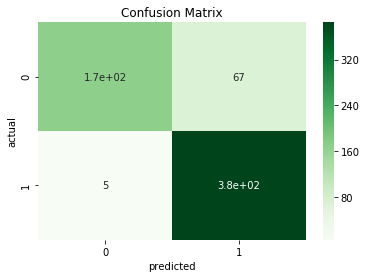

In [29]:
evaluation(class_list, preds)

#### Achieving an accuracy score of .88 on the hold out test data was better than we expected for a baseline model. I am going to try adding a normalization layer.

In [12]:
model = Sequential()
model.add(Convolution2D(32, (3,3), input_shape=(100,100,1), activation='relu'))
#Batch Normalization Layer
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=110, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

history = model.fit(train_data, epochs=30,  validation_data=(val_data))

Epoch 1/30
163/163 [==============================] - 52s 317ms/step - loss: 0.5674 - accuracy: 0.8898 - precision: 0.9253 - recall: 0.9265 - val_loss: 0.5608 - val_accuracy: 0.7917 - val_precision: 0.7619 - val_recall: 1.0000
Epoch 2/30
163/163 [==============================] - 51s 310ms/step - loss: 0.1637 - accuracy: 0.9339 - precision: 0.9554 - recall: 0.9556 - val_loss: 0.4454 - val_accuracy: 0.8750 - val_precision: 0.8421 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 50s 310ms/step - loss: 0.1606 - accuracy: 0.9396 - precision: 0.9597 - recall: 0.9590 - val_loss: 0.7883 - val_accuracy: 0.7083 - val_precision: 0.6957 - val_recall: 1.0000
Epoch 4/30
163/163 [==============================] - 50s 309ms/step - loss: 0.1441 - accuracy: 0.9425 - precision: 0.9599 - recall: 0.9628 - val_loss: 0.2591 - val_accuracy: 0.8333 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/30
163/163 [==============================] - 50s 309ms/step - loss: 0.1330 - accura

              precision    recall  f1-score   support

      NORMAL       0.84      0.88      0.86       234
   PNEUMONIA       0.93      0.90      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.89      0.88       624
weighted avg       0.89      0.89      0.89       624

Accurancy:  0.8910256410256411


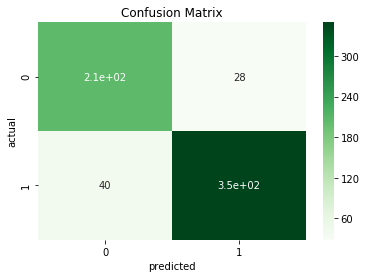

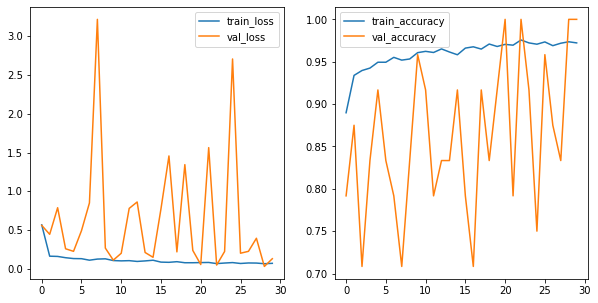

In [18]:
preds2 = model.predict_classes(data_array)
evaluation(class_list, preds2)

train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history.epoch, val_acc, ax=ax2, label='val_accuracy')

In [19]:
acc = model.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model.metrics_names, acc))

20/20 [==============================] - 3s 166ms/step - loss: 0.4264 - accuracy: 0.8910 - precision: 0.9259 - recall: 0.8974


[('loss', 0.42642614245414734),
 ('accuracy', 0.8910256624221802),
 ('precision', 0.9259259104728699),
 ('recall', 0.8974359035491943)]

              precision    recall  f1-score   support

      NORMAL       0.91      0.78      0.84       234
   PNEUMONIA       0.88      0.96      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624

Accurancy:  0.8894230769230769


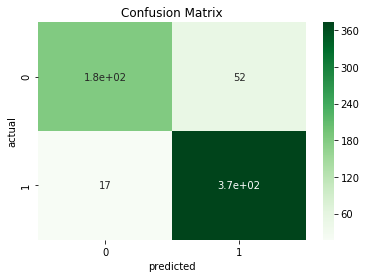

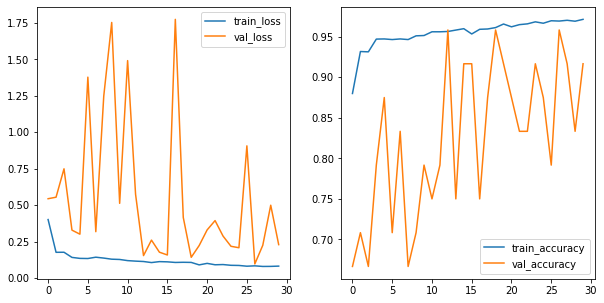

In [49]:
preds2 = model.predict_classes(data_array)
evaluation(class_l ist, preds2)

train_loss = model.history.history['loss']
train_acc = model.history.history['accuracy']
val_loss = model.history.history['val_loss']
val_acc = model.history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history.epoch, val_acc, ax=ax2, label='val_accuracy')

In [50]:
acc = model.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model.metrics_names, acc))

20/20 [==============================] - 5s 239ms/step


[('loss', 0.3413003087043762),
 ('accuracy', 0.8894230723381042),
 ('precision', 0.9691228866577148),
 ('recall', 0.9690080881118774)]

In [120]:
pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=4242d50ca9d5f223b7d6a501777148b0c1bb1d860abd8762b024b83700bbe6db
  Stored in directory: /Users/JasonWong/Library/Caches/pip/wheels/9c/e1/ab/1b35bf1600303ed3255d015ed61d064132e163386a94045081
Successfully built keras-resnet
Note: you may need to restart the kernel to use updated packages.


In [119]:
transfer_train_datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, 
                                                             zoom_range=0.2,
                                                             rescale=1./225)
transfer_val_datagen = keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2,
                                                                    rescale=1./225)
transfer_test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
transfer_train_data = transfer_train_datagen.flow_from_directory('data/chest_xray/train/')
                                               #target_size=(224,224),
                                               #batch_size=32,
                                               #class_mode='binary',
                                               #color_mode='grayscale')
transfer_val_data = transfer_val_datagen.flow_from_directory('data/chest_xray/val/')
                                               #target_size=(224,224),
                                               #batch_size=32,
                                               #class_mode='binary',
                                               #color_mode='grayscale')
transfer_test_data = transfer_test_datagen.flow_from_directory('data/chest_xray/test//')
                                             #target_size=(224,224),
                                             #batch_size=32,
                                             #class_mode='binary',
                                             #color_mode='grayscale')

Found 5217 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Converting the images is not needed for the resnet or the moblenet models

### Converting train images to RGB

In [120]:
batch_3 = transfer_train_data.next()
data_list = batch_3[0]
batch_index = 0
class_list = batch_3[1]
while batch_index <= transfer_train_data.batch_index:
    data = transfer_train_data.next()
    tr_train_data_list=np.concatenate((data_list, data[0]))
    tr_train_class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1
transfer_data_train = np.array(data_list)


In [ ]:
transfer_data_train.shape

In [178]:
train_image_RGB = np.ndarray(shape=(transfer_data_train.shape[0], transfer_data_train.shape[1], transfer_data_train.shape[2], 3), dtype= np.uint8) 


In [179]:
train_image_RGB.shape

(5216, 224, 224, 3)

### Converting validation images to RGB

In [121]:
batch_4 = transfer_val_data.next()
data_list = batch_4[0]
batch_index = 0
class_list = batch_4[1]
while batch_index <= transfer_val_data.batch_index:
    data = transfer_val_data.next()
    print(data[0].shape)
    tr_val_data_list=np.concatenate((data_list, data[0]))
    tr_val_class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1
transfer_data_val = np.asarray(data_list)

(24, 256, 256, 3)


In [182]:
val_image_RGB = np.ndarray(shape=(transfer_data_val.shape[0], transfer_data_val.shape[1], transfer_data_val.shape[2], 3), dtype= np.uint8) 
val_image_RGB.shape

(48, 224, 224, 3)

In [101]:
transfer_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 50, 50, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 50, 50, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 50, 50, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________

In [170]:
train_image_RGB.shape

(5120, 224, 224, 3)

### Defining the files for pnemonia and normal for training

In [78]:
tr_train_files = glob.glob('data/chest_xray/train/PNEUMONIA/*'),  glob.glob('data/chest_xray/train/NORMAL/*')

### Adding NORMAL images with the PNEUMONIA images
tr_train_files[0].extend(tr_train_files[1])




In [81]:
img_data_list = []
for img in tr_train_files[0]:
    img = image.load_img(img, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    print('input image shape:', x.shape)
    img_data_list.append(x)
        
img_data = np.array(img_data_list)
print(img_data.shape)
img_data = np.rollaxis(img_data,1,0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)

input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 224, 3)
input image shape: (1, 224, 

os.listdir(data_path)

In [82]:
tr_train_labels = [fn.split('\\')[-1].split('.')[0].strip() for fn in tr_train_files[0]]

tr_train_labels = [x[22] for x in tr_train_labels]

### Defining the files for pnemonia and normal for validation

In [85]:
tr_val_files = glob.glob('data/chest_xray/val/PNEUMONIA/*'), glob.glob('data/chest_xray/val/NORMAL/*'), 'rb'
tr_val_files[0].extend(tr_val_files[1])

In [92]:
val_img_data_list = []
for val_img in tr_val_files[0]:
    val_img = image.load_img(val_img, target_size=(224,224))
    x_val = image.img_to_array(val_img)
    x_val = np.expand_dims(x_val, axis=0)
    x_val = preprocess_input(x_val)
    val_img_data_list.append(x_val)
    
val_img_data = np.array(val_img_data_list)
val_img_data = np.rollaxis(val_img_data,1,0)
val_img_data = val_img_data[0]
print(val_img_data.shape)
    

(16, 224, 224, 3)


In [93]:
tr_val_labels = [fn.split('\\')[-1].split('.')[0].strip() for fn in tr_val_files[0]]

tr_val_labels = [x[20] for x in tr_val_labels]

In [94]:
le = LabelEncoder()
tr_train_labels_encoded = le.fit_transform(tr_train_labels)
tr_val_labels_encoded = le.transform(tr_val_labels)

### Attempt with resnet50

In [109]:
input_shape = Input(shape=(224,224,3))

In [165]:
base_model = ResNet50(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model.trainable=False

base_model.layers[-1].get_config()

In [168]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [169]:
from keras.models import Model
from keras import optimizers

In [170]:
img_data.shape

(5216, 224, 224, 3)

In [185]:
model2 = Sequential([base_model,
                    keras.layers.GlobalAveragePooling2D(),
                    keras.layers.Dense(50, activation='relu'),
                    keras.layers.Dense(1, activation='sigmoid')])

model2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [187]:
model2.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 50)                102450    
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 51        
Total params: 23,690,213
Trainable params: 102,501
Non-trainable params: 23,587,712
_________________________________________________________________


In [188]:
image_size=100
batch_size=32

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
train_data = train_datagen.flow_from_directory('data/chest_xray/train/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary')
                                               #color_mode='grayscale')
val_data = val_datagen.flow_from_directory('data/chest_xray/val/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary')
                                               #color_mode='grayscale')
test_data = test_datagen.flow_from_directory('data/chest_xray/test//',
                                             target_size=(100,100),
                                             batch_size=32,
                                             class_mode='binary')
                                             #color_mode='grayscale')

Found 5217 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [189]:
train_data.n // batch_size

163

In [191]:
epochs = 32

steps_per_epoch = train_data.n // batch_size

history = model2.fit(train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=val_data)

Epoch 1/32
163/163 [==============================] - 60s 371ms/step - loss: 0.4333 - accuracy: 0.7988 - precision: 0.8020 - recall: 0.9683 - val_loss: 0.5660 - val_accuracy: 0.7083 - val_precision: 0.6957 - val_recall: 1.0000
Epoch 2/32
163/163 [==============================] - 64s 394ms/step - loss: 0.3259 - accuracy: 0.8567 - precision: 0.8792 - recall: 0.9356 - val_loss: 0.5948 - val_accuracy: 0.7083 - val_precision: 0.6957 - val_recall: 1.0000
Epoch 3/32
163/163 [==============================] - 64s 395ms/step - loss: 0.2917 - accuracy: 0.8741 - precision: 0.8983 - recall: 0.9364 - val_loss: 0.8158 - val_accuracy: 0.7083 - val_precision: 0.6957 - val_recall: 1.0000
Epoch 4/32
163/163 [==============================] - 65s 399ms/step - loss: 0.2567 - accuracy: 0.8920 - precision: 0.9150 - recall: 0.9421 - val_loss: 0.5554 - val_accuracy: 0.7083 - val_precision: 0.6957 - val_recall: 1.0000
Epoch 5/32
163/163 [==============================] - 65s 396ms/step - loss: 0.2321 - accura

In [157]:
first_batch = test_data.next()
data_list = first_batch[0]
batch_index = 0
class_list = first_batch[1]
while batch_index <= test_data.batch_index:
    data = test_data.next()
    #print(data[0].shape)
    data_list=np.concatenate((data_list, data[0]))
    class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1
data_array = np.asarray(data_list)
data_array.shape

(624, 100, 100, 3)

In [192]:
acc = model2.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model2.metrics_names, acc))

20/20 [==============================] - 9s 433ms/step - loss: 0.6484 - accuracy: 0.7788 - precision: 0.7432 - recall: 0.9872


[('loss', 0.6484127640724182),
 ('accuracy', 0.7788461446762085),
 ('precision', 0.7432432174682617),
 ('recall', 0.9871794581413269)]

              precision    recall  f1-score   support

      NORMAL       0.95      0.43      0.59       234
   PNEUMONIA       0.74      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.85      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624

Accurancy:  0.7788461538461539


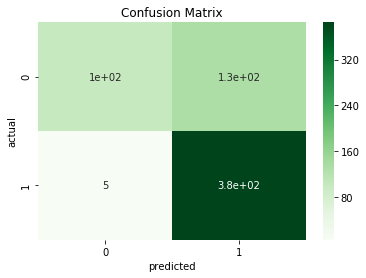

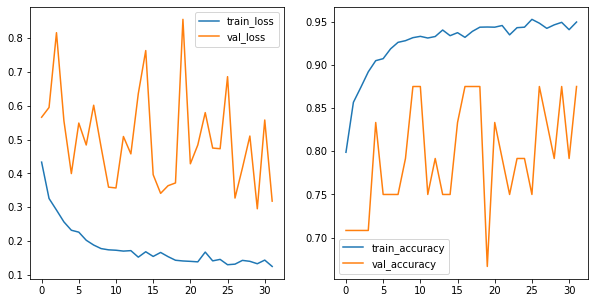

In [193]:
preds3 = model2.predict_classes(data_array)
evaluation(class_list, preds3)

train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history.epoch, val_acc, ax=ax2, label='val_accuracy')

### Fine Tuning

In [201]:
base_model.trainable = True
print('Number of layers in the base model: ', len(base_model.layers))

Number of layers in the base model:  175


In [202]:
# Fine tune beginning with this layer
fine_tune_at = 100

# Freezing the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [203]:
model2.compile(keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=METRICS)

In [212]:
tuned_history = model2.fit_generator(train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=val_data)

Epoch 1/32
163/163 [==============================] - 164s 1s/step - loss: 0.0940 - accuracy: 0.9730 - precision: 0.9821 - recall: 0.9816 - val_loss: 0.0553 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/32
163/163 [==============================] - 169s 1s/step - loss: 0.0652 - accuracy: 0.9776 - precision: 0.9864 - recall: 0.9834 - val_loss: 0.1831 - val_accuracy: 0.9167 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 3/32
163/163 [==============================] - 170s 1s/step - loss: 0.0635 - accuracy: 0.9755 - precision: 0.9836 - recall: 0.9834 - val_loss: 0.0710 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/32
163/163 [==============================] - 172s 1s/step - loss: 0.0678 - accuracy: 0.9745 - precision: 0.9814 - recall: 0.9844 - val_loss: 0.3953 - val_accuracy: 0.8333 - val_precision: 1.0000 - val_recall: 0.7500
Epoch 5/32
163/163 [==============================] - 173s 1s/step - loss: 0.0580 - accuracy: 0.9780

              precision    recall  f1-score   support

      NORMAL       1.00      0.02      0.04       234
   PNEUMONIA       0.63      1.00      0.77       390

    accuracy                           0.63       624
   macro avg       0.82      0.51      0.41       624
weighted avg       0.77      0.63      0.50       624

Accurancy:  0.6330128205128205


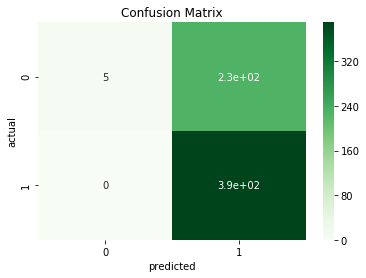

20/20 [==============================] - 8s 419ms/step - loss: 32.7054 - accuracy: 0.6330 - precision: 0.6300 - recall: 1.0000


[('loss', 32.70542526245117),
 ('accuracy', 0.6330128312110901),
 ('precision', 0.6300484538078308),
 ('recall', 1.0)]

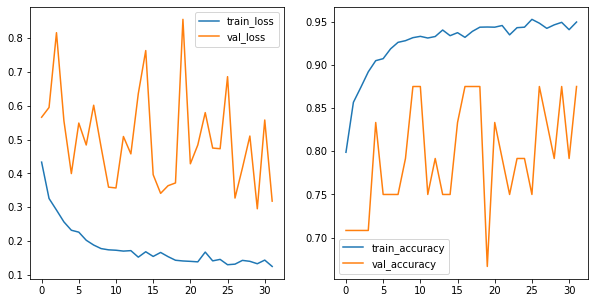

In [213]:
preds3_2 = model2.predict_classes(data_array)
evaluation(class_list, preds3_2)

train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = model2.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model2.metrics_names, acc))

In [206]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [207]:
base_model2 = MobileNetV2(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model2.trainable=False

base_model2.layers[-1].get_config()

9412608/9406464 [==============================] - 1s 0us/step


{'name': 'out_relu',
 'trainable': False,
 'dtype': 'float32',
 'max_value': array(6., dtype=float32),
 'negative_slope': array(0., dtype=float32),
 'threshold': array(0., dtype=float32)}

In [208]:
base_model2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [209]:
model3 = Sequential([base_model2,
                    keras.layers.GlobalAveragePooling2D(),
                    keras.layers.Dense(50, activation='relu'),
                    keras.layers.Dense(1, activation='sigmoid')])

model3.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [210]:
epochs = 32

steps_per_epoch = train_data.n // batch_size

history_mnv = model3.fit(train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=val_data)

Epoch 1/32
163/163 [==============================] - 26s 162ms/step - loss: 0.1939 - accuracy: 0.9227 - precision: 0.9612 - recall: 0.9630 - val_loss: 0.1663 - val_accuracy: 0.9583 - val_precision: 0.9412 - val_recall: 1.0000
Epoch 2/32
163/163 [==============================] - 26s 160ms/step - loss: 0.1185 - accuracy: 0.9533 - precision: 0.9684 - recall: 0.9689 - val_loss: 0.3177 - val_accuracy: 0.8750 - val_precision: 0.8421 - val_recall: 1.0000
Epoch 3/32
163/163 [==============================] - 27s 164ms/step - loss: 0.0941 - accuracy: 0.9620 - precision: 0.9736 - recall: 0.9753 - val_loss: 0.1993 - val_accuracy: 0.8750 - val_precision: 0.8421 - val_recall: 1.0000
Epoch 4/32
163/163 [==============================] - 29s 180ms/step - loss: 0.0879 - accuracy: 0.9645 - precision: 0.9766 - recall: 0.9756 - val_loss: 0.1709 - val_accuracy: 0.9167 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 5/32
163/163 [==============================] - 28s 173ms/step - loss: 0.0767 - accura

              precision    recall  f1-score   support

      NORMAL       0.99      0.41      0.58       234
   PNEUMONIA       0.74      1.00      0.85       390

    accuracy                           0.78       624
   macro avg       0.86      0.70      0.71       624
weighted avg       0.83      0.78      0.75       624

Accurancy:  0.7756410256410257


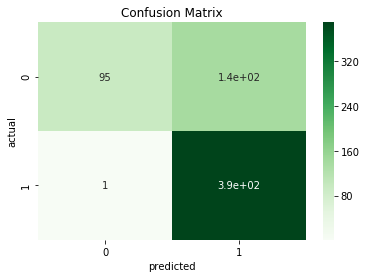

20/20 [==============================] - 6s 313ms/step - loss: 2.1571 - accuracy: 0.7756 - precision: 0.7367 - recall: 0.9974


[('loss', 2.1570730209350586),
 ('accuracy', 0.7756410241127014),
 ('precision', 0.7367424368858337),
 ('recall', 0.9974358677864075)]

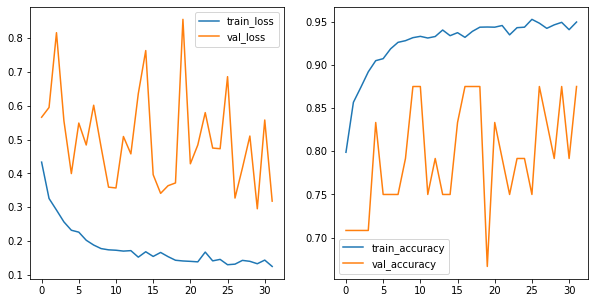

In [211]:
preds4 = model3.predict_classes(data_array)
evaluation(class_list, preds4)

train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = model3.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model3.metrics_names, acc))